In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')

print('Data source import complete.')


# CNN Cancer Detection Mini Project
The goal of this project is to build a model that can determine if microscopic slides of lymphnode tissue indicate cancerous cells or not. The data consists of 220k training images and 58k test images that are 96x96 pixels and 3 color channels (96x96x3). I will be using both custom convolutional networks and transfer learning from MobileNet and EfficientNetB0 to try and accomplish this task.


## Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import keras, os
import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, LeakyReLU, SpatialDropout2D
from keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split


In [ ]:
#Reading in the training data, we'll merge this with the given labels
pdir = histopathologic_cancer_detection_path
train_dir = os.path.join(pdir, 'train')

df_train = pd.DataFrame({'path': glob.glob(os.path.join(train_dir, '*.tif'))}) #Take all .tif files in training folder
df_train['id'] = df_train['path'].astype(str).str.extract(r'([^//]+).tif$') #Use filenames as ID
labels = pd.read_csv(os.path.join(pdir, 'train_labels.csv'))
df_train = df_train.merge(labels, on='id') #merge with labels
print(df_train.head(5))
print(df_train.info())
print(df_train['path'][0])

In [ ]:
#Creating dataframe with the test data in the same way
test_dir = os.path.join(pdir, 'test')
df_test = pd.DataFrame({'path': glob.glob(os.path.join(test_dir, '*.tif'))})
df_test['id'] = df_test['path'].str.extract(r'([^//]+).tif$')
print(df_test.head(5))
print(df_test.info())
print(df_test['path'][0])

In [ ]:
#Checking the distribution of classes
counts = df_train['label'].value_counts()
print(counts)
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Observations')
plt.title('Distribution of Labels in the Training Data')
plt.xticks(ticks=[0, 1], labels=['0: No Cancer', '1: Cancer'])
plt.show()

Looking at the distribution of our training data, we have an imbalanced set with more no cancer examples. Since we have a large enough dataset, I am simply going to remove some of the 0 labels until we have an equal number of cancerous and non-cancerous examples in our training set. This will prevent a bias toward one class.

In [ ]:
#Balancing the data by undersampling class 0
c0 = df_train[df_train['label'] == 0]
c1 = df_train[df_train['label'] == 1]

c0_bal = c0.sample(n=len(c1), random_state=1)

df_trainbal = pd.concat([c0_bal, c1], axis=0)

df_trainbal = df_trainbal.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:
#Checking the distribution of classes
counts = df_trainbal['label'].value_counts()
print(counts)
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Observations')
plt.title('Distribution of Labels in the Balanced Training Data')
plt.xticks(ticks=[0, 1], labels=['0: No Cancer', '1: Cancer'])
plt.show()

In [ ]:
random_samples = np.random.randint(1, len(df_trainbal) + 1, size=15)
for i in random_samples:

    image = mpimg.imread(df_trainbal['path'][i])
    imageplot = plt.imshow(image)
    plt.title('Label: ' + df_trainbal['label'][i].astype(str))
    plt.show()

Just looking at the images it is hard for me to tell the difference between cancerous and non-cancerous. It looks like maybe cancerous tissue is a bit darker overall than the non-cancerous but not by a whole lot. At this point our data is looking good to start modeling, we have a balanced dataset with almost 90k examples of both classes. In order to evaluate the models, I am going to monitor accuracy, AUC, and loss on training and validation sets at the end of each epoch and plot this at the end of training. Then we can make predictions on the test data and submit to the leaderboard. The metric on the test set is AUROC between prediction probability and actual label.

## Modeling
The first thing we need are image datagenerators which are required to feed our images into the models in batches so we don't run out of memory. An important thing to note here is that the training datagenerator is going to be performing augmentations to the training images to make them harder for the models and allowing them to learn more from them. I tried to only use augmentations that seemed realistic with these types of images, such as rotating, zooming, and flipping. The test and validation images should be easier for the model as they are not augmentated in any way. All pixel intensities will be normalized from 0-255 to 0-1.

In [ ]:
#Let's add a column with the full filenames for use with imagedatagenerator and labels must be strings
df_trainbal['filename'] = df_trainbal['id'] + '.tif'
df_test['filename'] = df_test['id'] + '.tif'
df_trainbal['label'] = df_trainbal['label'].astype(str)

In [ ]:
#Create training and validation sets with image datagenerator
train_df, val_df = train_test_split(df_trainbal, test_size=0.2, stratify=df_trainbal['label'], random_state=1)
train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True,
                                      vertical_flip=True, zoom_range=0.2, shear_range=0.2, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory=train_dir,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                    directory=train_dir,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode='binary')

In [ ]:
#Create the test image datagenerator
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                    directory=test_dir,
                                                    x_col='filename',
                                                    y_col=None,
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode=None,
                                                    shuffle=False)

The first model is a custom convolution network using convolution blocks like we learned in class with 2 filters followed by max pooling. I started off with relu activation but switched to leaky relu which performed better possibly due to vanishing gradient problems in the normal relu. I started with 1 block and worked up to 3 with improved performance. Other things added that improved performance were dropout and batch normalization. After the convolution blocks, the output goes into 2 dense layers using batch normalization and dropout reducing the inputs until the final output layer which uses sigmoid activation to make the classification.

In [ ]:
#Custom Convolution

model = Sequential()

# Conv block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.1))

# Conv block 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.15))

# Conv block 3 (new)
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.2))

# Dense layers
model.add(Flatten())
model.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))


initial_lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)



# Compile with updated optimizer
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

print(model.summary())

Here are the results from training
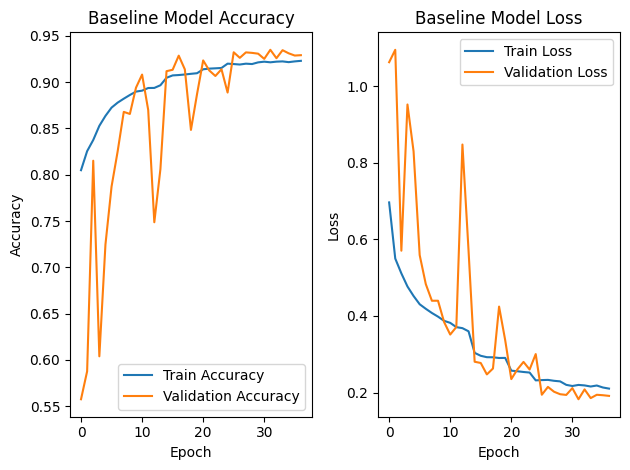

I tried transfer learning from MobileNet and EfficientNetB0 using the weights from imagenet. I didn't know how well this would work since the imagenet set seems quite different from the slides of lymphnode tissue. First let's look at MobileNet which worked well without having to unfreeze any weights. The dense and classification layers are the same as used with the custom convolution.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

initial_lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Compile with updated optimizer
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)
print(model.summary())

Here are the results from training 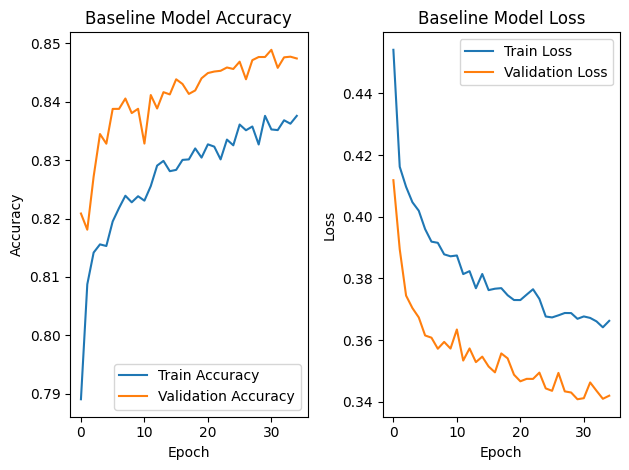 It was interesting how this model performed better on the validation data. I guess being pretrained and not having augmentation on the validation data accounts for this. Apparently the imagenet set has some features that are shared with the slides of lymphnode tissue.

With EfficientNetB0, I was not able to get it to work without unfreezing some of the layers and the plots indicated overfitting occuring very quickly while training accuracy increases validation starts to decrease like this 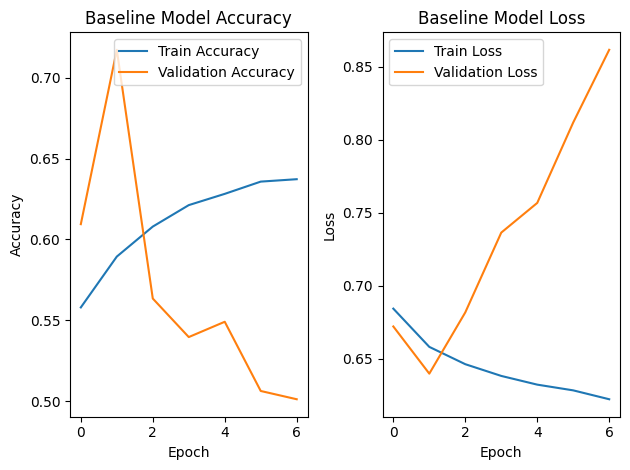

I finally got decent results when I unfroze the last 50 layers of the network to allow them to train on this data and using a lower initial learning rate of 1e-5.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras import layers, models

base_model = EfficientNetB0(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

# Unfreeze last 50 layers only
fine_tune_at = len(base_model.layers) - 50

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

inputs = tf.keras.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)  # Keeps BatchNorm in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

initial_lr = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Compile with updated optimizer
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)
print(model.summary())

Here are the results from this network 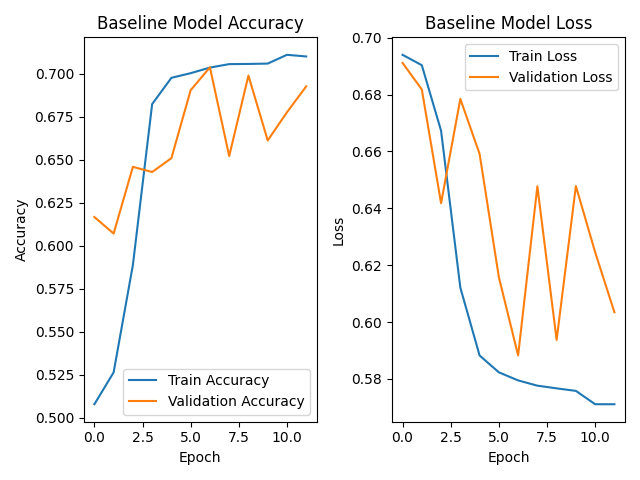 Performance is not quite as high with this model. It might need a lot more epochs to train using a lower learning rate and having more layers to train.

Just to show the code that was used to do the training and create the plots I am showing it here but you don't need to run this yourself. Improvements that were made here:


*   I increased number of epochs up from 10 to 50 since accuracy was still improving.
*   Early Stopping was implemented so I didn't waste time training once validation loss stopped decreasing.
*   Learning rate is set to decrease when it plateaus to see if smaller improvements can still be made.


In [ ]:
# Enhanced callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train with more epochs and callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Finally, I'll take the trained model and test generator to make predictions on the test set. I am taking a cutoff at 0.5 which is going to give us accuracy scores from the leaderboard.

In [ ]:
predictions = model.predict(test_generator, verbose=1)
predictions_int = (predictions > 0.5).astype(int)
submission = df_test.copy()
submission = submission.drop(columns=['filename', 'path'])
submission['label'] = predictions_int
print(submission.head())
submission.to_csv('3_convblocks_LeakyReLU_LRScheduler.csv', index=False)

# Results and Analysis
Here are the results from the various models on the test set which was submitted to the leaderboard for accuracy scores.
### Model Accuracy Comparison

| Model                     | Accuracy | Notes                                 |
|--------------------------|----------|---------------------------------------|
| Custom CNN               | 0.8659   | 3 conv layers, LeakyReLU, dropout     |
| MobileNetV2 (Transfer)   | 0.8294   | Frozen base, added dense head         |
| EfficientNetB0 (Transfer)| 0.6866   | Fine-tuned last 50 layers             |

The custom CNN was definitely the best model almost 4% more accurate than any of the best transfer learning model. Let's take a closer look at it's performance with a confusion matrix.




In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.sshow()

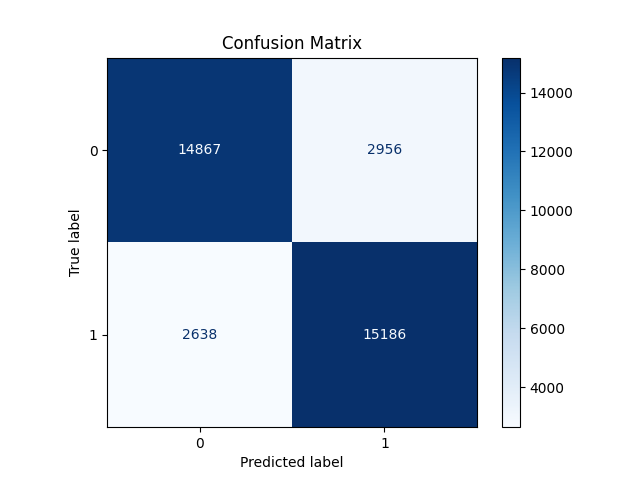
It looks like the model has a slight bias toward false negatives (2956) compared to false positives (2638), but they are fairly close. Since I used a balanced training set, this is what I expected. Overall the performance is pretty good. We could also look at the AUROC which is important especially in medical applications where false negatives (missed cancer) matter more than false positives.


In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

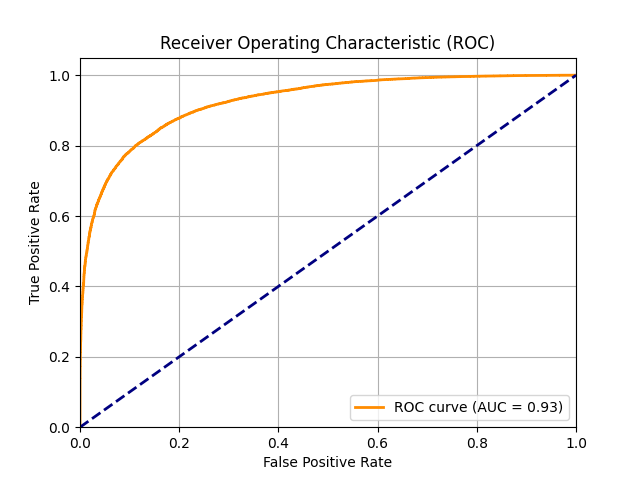
The curve suggests high sensitivity and specificity, and we should be able to find a threshold that would maximize our recall (false positive) rate. This would allow us to catch as many cancerous cases as possible without sacrificing overall performance of the model.

Several hyperparameters that were tuned in this project included

*   Optimizer: ADAM was the most successful optimizer that provided reliable convergence of the models.
*   Learning rate:  A learning rate of 1e-3 was most successful in all models except for EfficientnetB0 which required a lower learning rate of 1e-5 to successfully train the 50 unfrozen layers. I also reduced the learning rate when validation accuracy plateaus to see if smaller improvements can still be made.
*   Number of Epochs: I gave the models up to 50 epochs to find optimal performance and early stopping was implemented. Most models converged in 15-20 epochs but some took up to 35.


# Conclusion
Overall, the custom CNN had the highest performance. I think it outperformed the transfer learning models because the features of the microscopic lymphnode slides are different than the features in the imagenet set. When some of the layers of the models trained on imagenet were unfrozen and allowed to train on the lymphnode slides, I was able to improve the performance of the transfer learning model.

Things that worked:

*   Augmentations to the images in training allowed the models to learn more from the training data.
*   Batch normalization prevented the outputs from layers becoming too large.
*   LeakyReLu helped with vanishing gradients in the custom CNN.

Things that didn't work:

*   10 epochs was not enough to allow the models to reach peak performance
*   Early stopping might need to have the patience increased especially when the validation set has so much noise.

Things to try in the future:


*   For medical applications where maximizing recall is a priority, I would use the ROC Curve to select a threshold for labeling examples cancerous or not.
*   I plan to use a smaller set for initial training of the models to allow for faster iterations. The full set can be used when optimal parameters are found.
*   Saving models and histories is important when working in the notebooks, as runs can timeout and variables will be lost after long runs.

Citations:
ChatGPT and Gemini used to aid in coding and analysis.


In [ ]:
from IPython.display import display
display(None)  # flush lingering widgets